In [165]:
import numpy as np
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
import sympy as sp
import control as ctl

# FUNÇÃO DE TRANSFERÊNCIA

TransferFunction(array([1]), array([1, 2, 0]))

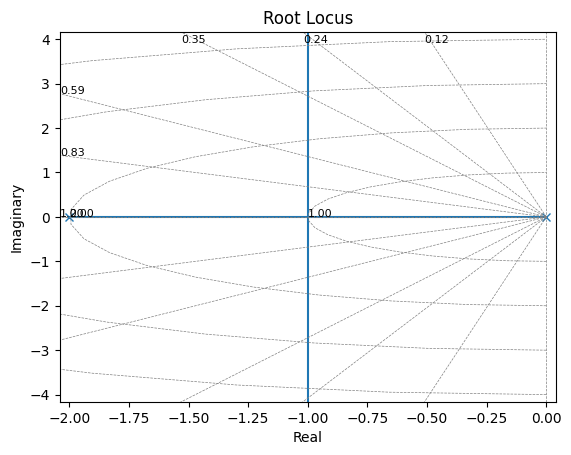

In [166]:
s = ctl.TransferFunction.s
G = 1/(s**2 + 2*s)

display(G)
_ = ctl.root_locus(G, plot=True)

[1]
[1 2 0]


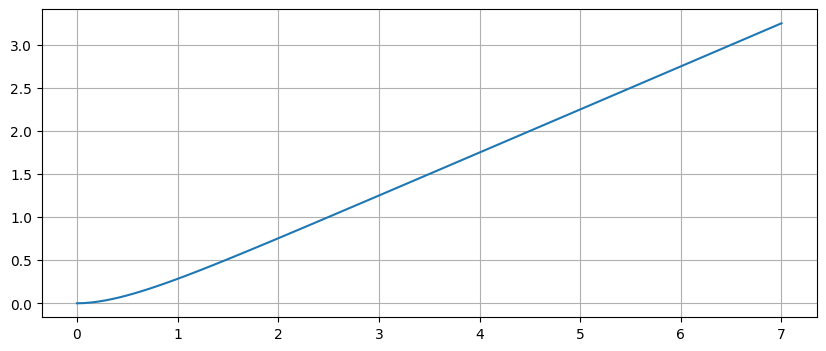

In [167]:
num, den = (G.num[0][0], G.den[0][0])
print(num)
print(den)

G = scipy.signal.lti(num, den)
time, response = G.step()

plt.figure(figsize=(10, 4))
plt.plot(time, response)
plt.grid()

# PARÂMETROS DO CONTROLADOR
- **M** define o número de passos de controle no horizonte de controle. Ele representa o período durante o qual o controlador pode ajustar as entradas (ações de controle) para tentar alcançar o setpoint. Esse valor é geralmente menor que o horizonte de predição, pois o controle é aplicado em uma janela mais curta, com o objetivo de minimizar o erro no futuro imediato.

- **P** representa o horizonte de predição, ou seja, quantos passos futuros o controlador tentará prever para ajustar a resposta do sistema. Ele define a "visão de futuro" do controlador, onde ele considera os valores de saída esperados em relação ao setpoint para minimizar os erros. Um horizonte de predição mais longo permite que o controlador tenha uma visão mais ampla do comportamento futuro.

- **dt** é o intervalo de tempo entre cada amostra, definindo o ritmo com que o sistema é atualizado e a frequência com que o controlador ajusta as ações de controle. No contexto de controle preditivo, dt afeta a resolução da previsão e controle, pois determina a granularidade do tempo, em que valores menores de dt permitem previsões mais detalhadas.

In [168]:
M = 10 # Control horizon
P = 20 # Prediction horizon

limits = (-100, 100)
bounds = [limits for i in range(M)]

- **rData** é o sinal de referência, definido como uma função exponencial que converge para o valor setpoint = 6. Esse é o objetivo que o controlador tenta alcançar e simulamos um comportamento ideal

- **tData** é o vetor no tempo discreto tem o tamanho do horizonte de predição

- **uData** é o vetor de controle que contém os valores de entrada aplicados ao sistema para aproximá-lo do setpoint desejado. Inicialmente, é definido com valores constantes, mas será ajustado pela otimização para minimizar o erro entre a resposta do sistema e o objetivo.

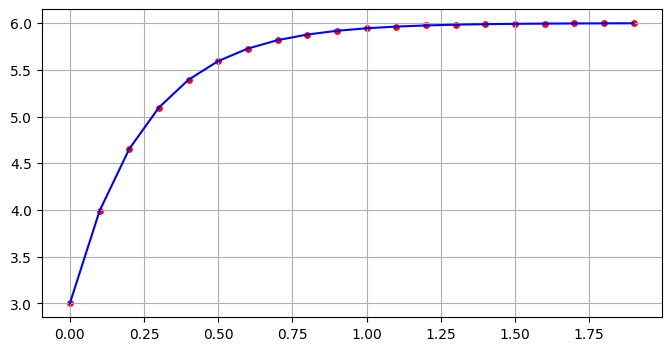

In [169]:
def getDesiredResponse(Ts, Xo, setpoint, dt):
    tData = np.arange(0, P*dt, dt)
    uData = np.ones(M)
    rData = Xo + (setpoint - Xo) * (1 - np.exp(-4*Ts * tData))
    return tData, uData, rData


setpoint = 6
dt = 0.1
Ts = 1
Xo = 3

X0 = Xo * np.ones(len(den) - 1)
tData, uData, rData = getDesiredResponse(Ts, Xo, setpoint, dt)

plt.figure(figsize=(8, 4))
plt.plot(tData, rData, color='blue')
plt.scatter(tData, rData, s=15, color='red')
plt.grid()
plt.show()

In [170]:
def extend(array, newSize):
    n = newSize - len(array)
    newData = np.repeat(array[-1], n)
    return np.concatenate([array, newData])


extend([1, 2, 3, 4], 10)

array([1, 2, 3, 4, 4, 4, 4, 4, 4, 4])

# SIMULANDO SISTEMA
- Forçando uma resposta no sistema $G$ com base em um vetor de entrada
- A função extendArray aumentando o tamanho do vetor de entrada $u$ para o tamanho que falta P, repetindo seu último valor

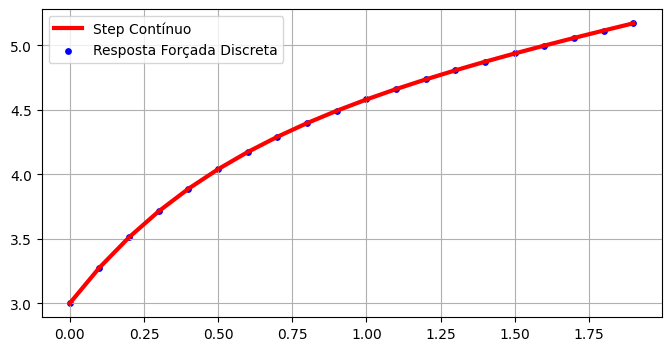

In [171]:
def simulateResponse(tData, uData, X0):
    return scipy.signal.lsim(G, U=uData, T=tData, X0=X0, interp=False)[1]


yData = simulateResponse(tData, extend(uData, P), X0=X0)
time, response = G.step(T=tData, X0=X0)

plt.figure(figsize=(8, 4))
plt.plot(time, response, color='red', linewidth=3, label='Step Contínuo')
plt.scatter(tData, yData, color='blue', s=15, label='Resposta Forçada Discreta')
plt.grid()
plt.legend()

# TREINANDO MODELO
- A função abaixo calcula a soma dos quadrados dos erros para saber a distancia que estamos do objetivo (diferença entre o setpoint e a entrada), ou seja, é o erro com base nos valores de um vetor

In [172]:
def getError(uData, tData, X0):
    yData = simulateResponse(tData, extend(uData, P), X0)
    return sum((rData - yData)**2)


getError(uData, tData, X0=X0) # erro mt grande

29.527326945945507

- Com a medição do erro medido em objective, usamos scipy.optimize para encontrar a saída que minimiza esse erro, ou seja, qual é a entrada que temos que aplicar para minimizar esse erro

**OBS:** Para deixar mais rapido esta etapa, mude o campo method:
- **None**: Padrão
- **Nelder-Mead**: Método simplex, robusto, lento e sem suporte para limites ou restrições.
- **Powell**: Busca direcional, eficiente para problemas unidimensionais com limites.
- **CG**: Gradiente conjugado, rápido, mas sem suporte para limites ou restrições.
- **BFGS**: Quasi-Newton, eficiente para funções suaves sem limites ou restrições.
- **L-BFGS-B**: Variante do BFGS que suporta limites, ideal para problemas médios-grandes.
- **TNC**: Newton truncado, suporta limites simples, mas não restrições gerais.
- **COBYLA**: Método sem derivadas para problemas com restrições gerais.
- **SLSQP**: Suporta limites e restrições gerais com boa eficiência em problemas médios.
- **trust-constr**: Método robusto para problemas com limites e restrições complexas.
- **Newton-CG**: Usa gradientes e Hessiana, eficiente para problemas suaves e grandes.
- **Dogleg**: Baseado em segunda ordem, eficiente para pequenos problemas suaves.
- **Trust-Krylov**: Método avançado para grandes problemas suaves sem limites ou restrições.

In [173]:
result = scipy.optimize.minimize(getError, uData, args=(tData, X0), bounds=bounds, method=None, tol=1e-6)
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.06258313395862827
        x: [ 1.000e+02 -3.148e+01 -2.589e+01 -5.527e-01 -2.189e+00
            -5.762e+00 -1.187e+00  1.216e+00 -3.290e+00 -1.069e-01]
      nit: 59
      jac: [-2.524e-03 -6.686e-05 -7.416e-05 -9.125e-05 -3.748e-05
            -6.422e-05 -3.956e-05 -2.590e-05 -6.338e-05 -5.467e-05]
     nfev: 748
     njev: 68
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

In [174]:
error = result.fun
error

0.06258313395862827

# TESTANDO MODELO

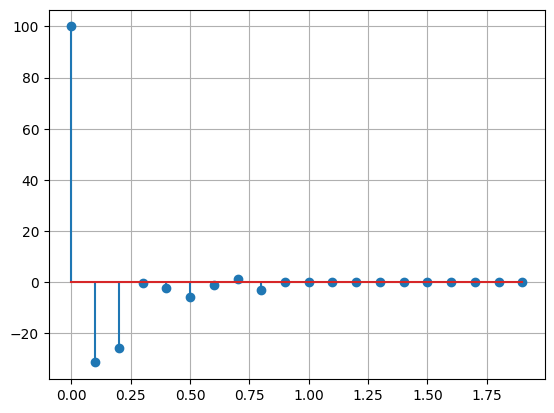

In [175]:
output = result.x
output = extend(output, len(tData))

plt.stem(tData, output)
plt.grid()

In [176]:
len(result.x) == M # próximas 10 ações de conrole

True

Resample the discrete output to continuous time (effectively work out the 0 order hold value)

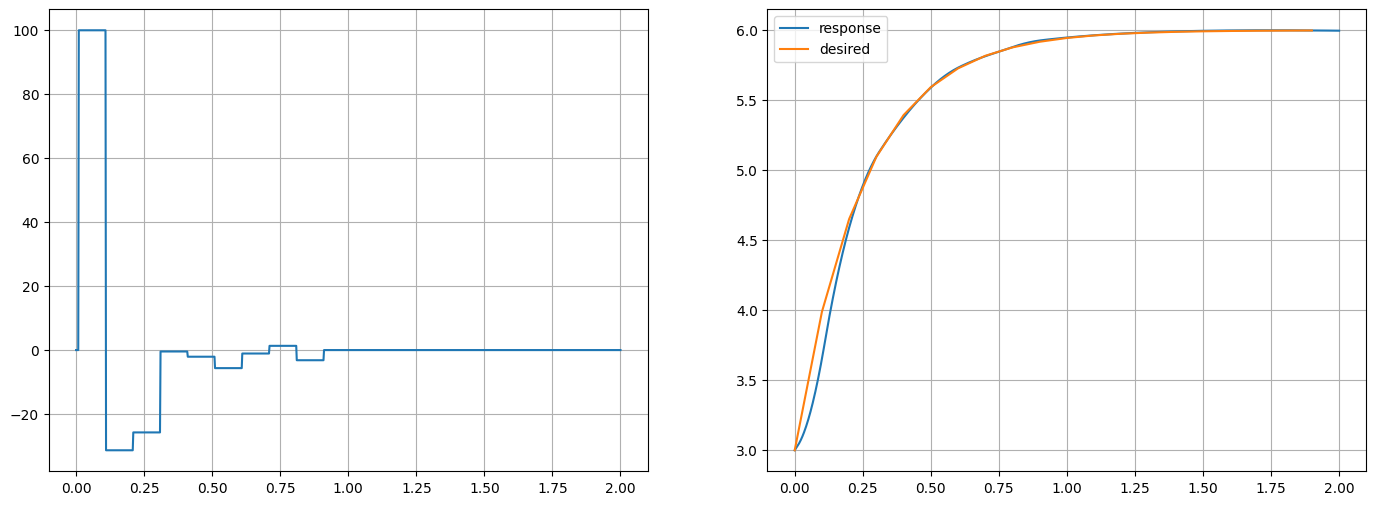

In [177]:
def getContinousArray(time, response, dt):
    indices = (time - 0.01) // dt
    return response[indices.astype(int)]


tData   = np.linspace(0, P*dt, 1000)  
output  = getContinousArray(tData, output, dt)
yData   = simulateResponse(tData, output, X0)
t, u, y = getDesiredResponse(Ts, Xo, setpoint, dt)

plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
plt.plot(tData, output)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(tData, yData, label='response')
plt.plot(t, y, label='desired')
plt.legend()
plt.grid()